In [1]:
reset -fs

In [2]:
# import libraries
import pandas as pd
import numpy as np
import re
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Read in data

In [3]:
modern_love_df = pd.read_csv('modern_love_df.csv')

In [4]:
modern_love_df.shape

(1615, 12)

In [5]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_url             1615 non-null   object
 1   article                 1609 non-null   object
 2   article_id              1615 non-null   object
 3   article_headline        1615 non-null   object
 4   article_abstract        1615 non-null   object
 5   article_snippet         1615 non-null   object
 6   article_lead_paragraph  1604 non-null   object
 7   article_pub_date        1615 non-null   object
 8   article_news_desk       1615 non-null   object
 9   article_section         1615 non-null   object
 10  article_type_material   1615 non-null   object
 11  article_word_count      1615 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 151.5+ KB


# Clean data

In [6]:
pd.set_option("display.max_colwidth", 1)

In [7]:
# drop rows with na in article column

modern_love_df = modern_love_df.dropna(subset=['article'])

In [8]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_url             1609 non-null   object
 1   article                 1609 non-null   object
 2   article_id              1609 non-null   object
 3   article_headline        1609 non-null   object
 4   article_abstract        1609 non-null   object
 5   article_snippet         1609 non-null   object
 6   article_lead_paragraph  1599 non-null   object
 7   article_pub_date        1609 non-null   object
 8   article_news_desk       1609 non-null   object
 9   article_section         1609 non-null   object
 10  article_type_material   1609 non-null   object
 11  article_word_count      1609 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 163.4+ KB


In [9]:
# rename article column

modern_love_df = modern_love_df.rename({'article':'essay'}, axis=1)

In [10]:
# rename the rest of the columns by removing 'article_'

modern_love_df.columns = modern_love_df.columns.str.replace('article_',"")

In [11]:
# check for duplicated rows

modern_love_df.duplicated().sum() # there are none!

0

In [12]:
# convert pub_date to datetime and then keep only the date

modern_love_df['pub_date'] = pd.to_datetime(modern_love_df['pub_date']).dt.date

In [13]:
modern_love_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1614
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             1609 non-null   object
 1   essay           1609 non-null   object
 2   id              1609 non-null   object
 3   headline        1609 non-null   object
 4   abstract        1609 non-null   object
 5   snippet         1609 non-null   object
 6   lead_paragraph  1599 non-null   object
 7   pub_date        1609 non-null   object
 8   news_desk       1609 non-null   object
 9   section         1609 non-null   object
 10  type_material   1609 non-null   object
 11  word_count      1609 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 163.4+ KB


In [17]:
# see how many articles mention the nytimes in the essay, as this text should be removed

len(modern_love_df[modern_love_df.essay.str.contains('nytimes|New York Times|NYT')])

108

In [18]:
# drop these essays for times' sake (go back to data acquisition stage to remove these paragraphs, time permitting)

modern_love_df_rev = modern_love_df[~modern_love_df.essay.str.contains('nytimes|New York Times|NYT')]

In [19]:
# see how many essays mention 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?”'

print(len(modern_love_df_rev[modern_love_df_rev.essay.str.contains('collaborative project')]))

8


In [20]:
# remove the sentences 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?”'
    # from the essay column

sentences_to_remove = 'This essay is part of a collaborative project with Black History, Continued. We invited readers and renowned writers to respond to the question “What is Black love today?” '
print(len(sentences_to_remove))

collaborative_project = modern_love_df_rev[modern_love_df_rev.essay.str.contains('collaborative project')]

revised_text = []

for row in collaborative_project['essay']:
    row = row[172:]
    revised_text.append(row)
    
index = collaborative_project['id']

data_tuples = list(zip(index,revised_text))
cleaned_essay = pd.DataFrame(data_tuples, columns=['id','essay_rev'])

modern_love_df_rev = modern_love_df.merge(cleaned_essay,how='left',on='id')
modern_love_df_rev['essay_rev'].fillna(modern_love_df_rev.essay, inplace=True)

172


In [21]:
# check how many essays include text for the link '[Sign up for Love Letter, our weekly email about Modern Love, weddings and relationships.]'

len(modern_love_df_rev.loc[modern_love_df_rev.essay_rev.str.contains('Sign up for Love Letter')])

111

In [22]:
# remove the sign-up link text from each article

modern_love_df_rev['essay_rev'] = modern_love_df_rev['essay_rev'].str.replace(r'\[.*?\]','')

In [23]:
# check how many essays have 'Modern Love' in them

len(modern_love_df_rev.loc[modern_love_df_rev.essay_rev.str.contains('Modern Love|modernlove')])

151

In [24]:
# drop these essays 

modern_love_df_rev_2 = modern_love_df_rev.loc[~modern_love_df_rev.essay_rev.str.contains('Modern Love|modernlove')]

In [25]:
modern_love_df_rev_2.shape

(1458, 13)

In [999]:
modern_love_df_rev_2.columns

Index(['url', 'essay', 'id', 'headline', 'abstract', 'snippet',
       'lead_paragraph', 'pub_date', 'news_desk', 'section', 'type_material',
       'word_count', 'essay_rev', 'essay_rev_clean', 'essay_rev_clean_2',
       'essay_rev_clean_3'],
      dtype='object')

# NMF topic modeling utility

Before creating a baseline model, create a pipeline function that does the following:

- Arguments are the corpus, vectorizer and topic_modeler
- Applies these in order
- Prints the top 10 words for each topic found from training

In [726]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=10):
    """A very simple pipeline."""
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus) 
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = doc_word_vectors.get_feature_names_out() # vectorizer
    for idx, topic in enumerate(doc_topic_vectors.components_): # topic_modeler
        # Select the top 10 words in vocab for this topic.
        top_words = [vocab[i] for i in topic.argsort()[:-print_n_words-1:-1]]
        #print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
        print(f"Topic {idx}:", ", ".join(top_words))
        
    return doc_topic_vectors

# NMF baseline model

As priors, use Tfidf vectorizer and NMF topic modeler

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [28]:
corpus = modern_love_df_rev_2['essay_rev']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(5, random_state=42, max_iter=1000) # start with 5 topics

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: the, and, of, to, in, that, was, it, had, my
Topic 1: she, her, was, to, and, the, me, had, in, for
Topic 2: he, his, him, to, was, me, and, said, had, you
Topic 3: we, our, and, in, the, to, you, us, other, together
Topic 4: my, mother, father, me, to, parents, and, with, in, for


array([[0.12026731, 0.        , 0.1151798 , 0.03879698, 0.01190443],
       [0.10574248, 0.01946263, 0.06163275, 0.05058978, 0.03135195],
       [0.06828757, 0.15704441, 0.        , 0.00618065, 0.07139688],
       ...,
       [0.        , 0.        , 0.05832072, 0.04512847, 0.        ],
       [0.03195689, 0.        , 0.        , 0.00845712, 0.0650467 ],
       [0.05628714, 0.00129334, 0.00476101, 0.013898  , 0.02507168]])

Looks like the topics are capturing lots of stop words - time to remove them!

# NMF Model 2 - remove stop words, numbers, punctuation and lemmatize tokens

Use spaCy package for text processing

In [29]:
import spacy
from spacy.tokens import Token
nlp = spacy.load('en_core_web_sm')

In [30]:
# import stopwords
sw_spacy = nlp.Defaults.stop_words

The below code was inspired by this <a href="https://stackoverflow.com/questions/47523112/detect-stopword-after-lemma-in-spacy">this stackoverflow post</a>

In [31]:
# update stopwords to ensure that capitalized and lemmatized tokens are identified as stop words

stop_words_getter = lambda token: token.is_stop or token.lower_ in sw_spacy or token.lemma_ in sw_spacy
Token.set_extension('is_stop', getter=stop_words_getter, force=True)  # set attribute with getter

In [32]:
docs = list(nlp.pipe(modern_love_df_rev_2['essay_rev']))

The below code was inspired by <a href="https://stackoverflow.com/questions/25692293/inserting-a-link-to-a-webpage-in-an-ipython-notebook">this stackoverflow post</a>

In [33]:
docs_clean = [[token.lemma_.lower() for token in doc if token.is_alpha and \
                         (not token.is_stop and not token.is_punct and not token.like_num and not token.is_digit)] \
                          for doc in docs]
modern_love_df_rev_2['essay_rev_clean'] = [' '.join(map(str, l)) for l in docs_clean]

<ipython-input-33-3405cf085942>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modern_love_df_rev_2['essay_rev_clean'] = [' '.join(map(str, l)) for l in docs_clean]


In [34]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(5, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: day, time, like, say, home, go, night, bed, leave, know
Topic 1: father, mother, parent, family, say, brother, year, sister, child, know
Topic 2: say, date, like, want, man, know, think, tell, woman, meet
Topic 3: husband, marriage, divorce, wife, marry, child, year, wedding, friend, life
Topic 4: love, fall, year, grandmother, girl, boy, know, feel, relationship, child


array([[0.07236249, 0.05994489, 0.05163971, 0.02300993, 0.03358636],
       [0.01151929, 0.06829537, 0.01585402, 0.06786783, 0.07423379],
       [0.03034165, 0.02797976, 0.0203942 , 0.00605542, 0.13180721],
       ...,
       [0.02773193, 0.        , 0.        , 0.01958957, 0.04469718],
       [0.02239977, 0.00234048, 0.        , 0.10264239, 0.        ],
       [0.04431684, 0.        , 0.01291339, 0.        , 0.01675162]])

# NMF Model 3 - try 10 topics

In [35]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(10, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: mother, grandmother, year, family, sister, parent, home, old, die, care
Topic 1: father, parent, mother, brother, dad, family, know, year, sister, die
Topic 2: date, like, want, relationship, man, feel, woman, friend, know, time
Topic 3: husband, marriage, divorce, wife, marry, year, wedding, friend, man, life
Topic 4: love, fall, year, word, know, heart, feel, relationship, people, write
Topic 5: say, ask, tell, know, think, want, yes, like, look, later
Topic 6: day, time, night, new, home, like, car, leave, bed, dog
Topic 7: child, baby, daughter, son, doctor, birth, pregnancy, pregnant, know, husband
Topic 8: john, amy, mary, house, slipper, year, want, extraordinary, day, sofa
Topic 9: girl, school, boy, prom, parent, michael, high, gay, dress, year


array([[0.00611814, 0.0547847 , 0.05585934, ..., 0.12416781, 0.        ,
        0.        ],
       [0.03177836, 0.05230815, 0.00942886, ..., 0.01877506, 0.001906  ,
        0.02563816],
       [0.01113183, 0.0195127 , 0.02676823, ..., 0.04980819, 0.00204291,
        0.034947  ],
       ...,
       [0.        , 0.00666873, 0.        , ..., 0.        , 0.00466373,
        0.00651875],
       [0.00162195, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00259708, ..., 0.        , 0.        ,
        0.        ]])

# NMF Model 4 - try 50 topics

In [36]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(50, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: feel, know, relationship, time, want, like, way, life, think, friend
Topic 1: father, dad, mother, parent, know, die, year, death, daddy, life
Topic 2: date, meet, guy, app, friend, year, maybe, try, marry, later
Topic 3: marriage, divorce, wife, marry, year, gay, married, couple, wedding, share
Topic 4: love, fall, year, boyfriend, heart, word, milo, people, write, child
Topic 5: say, ask, tell, know, think, yes, want, like, good, happy
Topic 6: new, apartment, night, york, day, city, work, boyfriend, move, time
Topic 7: baby, child, pregnancy, pregnant, birth, fertility, adoption, egg, doctor, sperm
Topic 8: mother, home, year, old, care, die, day, dj, cry, family
Topic 9: man, woman, guy, white, like, young, find, gay, think, know
Topic 10: john, mary, slipper, house, extraordinary, want, sofa, party, bee, jessica
Topic 11: grandmother, mahjong, tile, nick, game, purse, win, round, aunt, cousin
Topic 12: son, child, house, wife, boy, year, church, god, tree, old
Topic 13: m

array([[0.03785426, 0.04446844, 0.01136468, ..., 0.03843785, 0.05835881,
        0.        ],
       [0.00599239, 0.02545525, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01788923, 0.01264681, 0.00522237, ..., 0.00494933, 0.        ,
        0.        ],
       ...,
       [0.00627784, 0.00466612, 0.        , ..., 0.00769902, 0.001398  ,
        0.0079676 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02583937,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00073479,
        0.        ]])

# NMF Model 5 - try 2 topics

In [37]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(2, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: say, like, love, know, want, time, feel, think, tell, man
Topic 1: mother, father, parent, year, family, child, daughter, say, son, brother


array([[0.08506482, 0.0791229 ],
       [0.04808149, 0.08981857],
       [0.0613017 , 0.05350221],
       ...,
       [0.0325893 , 0.01562112],
       [0.03759431, 0.0286379 ],
       [0.04365331, 0.        ]])

# NMF Model 6 - try 7 topics

In [38]:
corpus = modern_love_df_rev_2['essay_rev_clean']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(7, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: day, time, like, home, bed, night, feel, go, leave, come
Topic 1: father, mother, parent, family, brother, year, sister, child, die, know
Topic 2: date, like, relationship, want, man, friend, feel, know, time, woman
Topic 3: husband, marriage, divorce, wife, marry, child, year, wedding, friend, life
Topic 4: love, grandmother, fall, year, boy, child, girl, parent, know, family
Topic 5: say, ask, tell, know, think, want, like, yes, look, later
Topic 6: john, amy, year, mary, house, slipper, want, school, high, new


array([[6.94770303e-02, 5.95715739e-02, 5.64972297e-02, ...,
        2.49154081e-02, 2.61863639e-02, 0.00000000e+00],
       [1.12106189e-02, 6.71349062e-02, 2.23416241e-02, ...,
        6.87913745e-02, 1.58993337e-02, 3.68147979e-03],
       [3.09364201e-02, 2.69966857e-02, 3.52077018e-02, ...,
        1.22663658e-01, 4.63760672e-03, 2.44690127e-03],
       ...,
       [2.78458568e-02, 0.00000000e+00, 3.78684335e-05, ...,
        4.32893509e-02, 3.50992582e-03, 7.85271941e-03],
       [1.05131888e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.80152476e-02, 0.00000000e+00],
       [3.91264770e-02, 0.00000000e+00, 1.62182190e-02, ...,
        1.08950736e-02, 1.17952016e-02, 5.02625520e-03]])

# NMF Model 7 - 10 topics and remove more stop words

In [816]:
tokens_to_remove = {'like','tell','like','want','say','know','ask','think','thing','man','woman','feel','person', \
                   'people','day','time','night', 'come'}

sw_spacy.update(tokens_to_remove)

docs_clean_2 = [[token for token in doc if token not in sw_spacy] for doc in docs_clean]
modern_love_df_rev_2['essay_rev_clean_2'] = [' '.join(map(str, l)) for l in docs_clean_2]

In [817]:
docs_2 = list(nlp.pipe(modern_love_df_rev_2['essay_rev_clean_2']))

In [818]:
corpus = modern_love_df_rev_2['essay_rev_clean_2']
vectorizer = TfidfVectorizer()
topic_modeler = NMF(10, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: look, car, bed, home, hand, leave, dog, walk, room, new
Topic 1: father, parent, mother, brother, dad, year, family, die, sister, life
Topic 2: date, meet, friend, relationship, guy, talk, message, year, new, good
Topic 3: husband, marriage, divorce, wife, marry, year, child, wedding, friend, life
Topic 4: love, fall, year, relationship, word, heart, child, life, write, boyfriend
Topic 5: grandmother, mahjong, year, tile, game, grandfather, nick, win, die, purse
Topic 6: girl, school, boy, prom, high, gay, parent, michael, dress, wear
Topic 7: mother, child, daughter, baby, parent, family, son, year, birth, home
Topic 8: john, amy, mary, house, year, slipper, party, extraordinary, new, sofa
Topic 9: sex, sexual, body, relationship, kiss, boyfriend, desire, affair, lover, room


array([[0.04801425, 0.05541306, 0.04578253, ..., 0.0548223 , 0.        ,
        0.02809565],
       [0.00762077, 0.05306614, 0.0036622 , ..., 0.03793825, 0.00205461,
        0.01226042],
       [0.02685096, 0.01675163, 0.01652142, ..., 0.03000346, 0.00037356,
        0.        ],
       ...,
       [0.01824226, 0.0078459 , 0.0078799 , ..., 0.        , 0.00519347,
        0.        ],
       [0.02423751, 0.        , 0.        , ..., 0.00025523, 0.        ,
        0.        ],
       [0.03360477, 0.        , 0.03088206, ..., 0.        , 0.00240991,
        0.0021559 ]])

# NMF Model 8 - 8 topics and tune max_df and min_df

In [819]:
corpus = modern_love_df_rev_2['essay_rev_clean_2']
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.02)
topic_modeler = NMF(8, random_state=42, max_iter=1000)

make_topics(corpus, vectorizer, topic_modeler)

Topic 0: look, hand, bed, room, leave, eye, body, dog, way, car
Topic 1: father, parent, brother, dad, family, sister, mother, father die, die, death
Topic 2: date, friend, relationship, meet, guy, sex, good, talk, find, way
Topic 3: husband, marriage, wife, marry, divorce, wedding, friend, life, married, ex
Topic 4: mother, grandmother, sister, family, die, parent, old, home, care, cry
Topic 5: new, york, new york, city, york city, new york city, apartment, live, later, home
Topic 6: child, daughter, son, baby, boy, family, parent, school, girl, birth
Topic 7: john, school, mary, house, high, party, high school, sofa, find love, meet


array([[0.05409715, 0.07560415, 0.05955524, ..., 0.00737279, 0.09689404,
        0.        ],
       [0.        , 0.07631739, 0.        , ..., 0.18176007, 0.07360179,
        0.        ],
       [0.04765167, 0.03070896, 0.05571018, ..., 0.0465387 , 0.14372252,
        0.00306682],
       ...,
       [0.02292997, 0.00680569, 0.01113742, ..., 0.01148343, 0.00166265,
        0.00538585],
       [0.02404266, 0.00158322, 0.        , ..., 0.00837544, 0.01820894,
        0.        ],
       [0.        , 0.        , 0.00876386, ..., 0.21140442, 0.        ,
        0.        ]])

# NMF Model 9 - 8 topics and customize some lemmatization

The below code was inspired by this <a href="https://medium.com/mlearning-ai/nlp-03-lemmatization-and-stemming-using-spacy-b2829becceca">this medium post</a>

In [820]:
# customize lemmatization for married and marriage so their lemma is 'marry'; 
    # dad and daddy so their lemma is 'father'
    # mom and mommy so their lemma is 'mother'
    # pregnant so it's lemma is 'pregnancy'
    # grandma so its lemma is 'grandmother'
    # grandpa so its lemma is 'grandfather'
    # die so its lemma is 'death'

nlp.get_pipe('attribute_ruler').add([[{"TEXT":"married"}]],{"LEMMA":"marriage"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"marry"}]],{"LEMMA":"marriage"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"dad"}]],{"LEMMA":"father"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"daddy"}]],{"LEMMA":"father"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"mom"}]],{"LEMMA":"mother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"mommy"}]],{"LEMMA":"mother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"pregnant"}]],{"LEMMA":"pregnancy"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"grandma"}]],{"LEMMA":"grandmother"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"grandpa"}]],{"LEMMA":"grandfather"})
nlp.get_pipe('attribute_ruler').add([[{"TEXT":"die"}]],{"LEMMA":"death"})

In [821]:
docs_3 = list(nlp.pipe(modern_love_df_rev_2['essay_rev_clean_2']))

In [822]:
docs_clean_3 = [[token.lemma_ for token in doc] for doc in docs_3]
modern_love_df_rev_2['essay_rev_clean_3'] = [' '.join(map(str, l)) for l in docs_clean_3]

In [834]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.01)
topic_modeler = NMF(10, random_state=42, max_iter=1000)

nmf_doc_topic = make_topics(corpus, vectorizer, topic_modeler)

Topic 0: look, hand, leave, dog, bed, car, walk, room, home, way
Topic 1: father, parent, death, brother, father death, family, sister, divorce, mother, old
Topic 2: marriage, husband, divorce, wife, wedding, friend, life, ring, couple, gay
Topic 3: date, friend, meet, relationship, guy, message, good, write, find, talk
Topic 4: mother, parent, family, sister, brother, home, cry, old, good, house
Topic 5: new, york, new york, city, york city, new york city, apartment, live, later, month
Topic 6: child, baby, daughter, son, pregnancy, boy, family, birth, doctor, life
Topic 7: sex, sexual, relationship, boyfriend, kiss, desire, body, partner, fall, lover
Topic 8: grandmother, grandfather, sister, tile, death, family, game, win, granddaughter, old
Topic 9: john, amy, house, mary, school, sofa, high, party, jessica, high school


The above topics seem like they could be loosely described as the following:

- Topic 1: misc
- Topic 2: immediate family/family tragedies
- Topic 3: marriage and divorce
- Topic 4: dating
- Topic 5: family
- Topic 6: new york city
- Topic 7: pregnancy and birth
- Topic 8: sex and desire
- Topic 9: grandparents and grandchildren
- Topic 10: school/high school

Create a dataframe  from the topic-word matrix (aka W) that shows us the topics and the terms associated with each topic. The values in each cell are the weights of each word (column) on each topic (row).

In [836]:
topic_word = pd.DataFrame(topic_modeler.components_,
             index = ["component_1","component_2","component_3","component_4","component_5","component_6",
                     "component_7","component_8", "component_9", "component_10"],
             columns = vectorizer.get_feature_names())
topic_word

,abandon,ability,able,abroad,abruptly,absence,absent,absolutely,absorb,absurd,...,york city,yorker,young,young brother,young child,young girl,young sister,youth,zone,zoom
component_1,0.017295,0.011786,0.047757,0.001536,0.005711,0.018236,0.005629,0.005763,0.012779,0.009703,...,0.000000,0.000293,0.054875,0.000000,0.000000,0.006491,0.004852,0.011312,0.007864,0.011752
component_2,0.000000,0.001130,0.018885,0.000000,0.000000,0.022182,0.001300,0.001976,0.000042,0.003306,...,0.000000,0.000000,0.045355,0.009832,0.004914,0.001736,0.019540,0.000000,0.000000,0.000000
component_3,0.000000,0.023972,0.033550,0.001939,0.000000,0.009851,0.000950,0.013009,0.000000,0.000397,...,0.000000,0.002573,0.064294,0.003237,0.000501,0.000000,0.003200,0.000000,0.001775,0.000000
component_4,0.007267,0.017449,0.046691,0.009476,0.009556,0.000000,0.000973,0.011558,0.000000,0.005352,...,0.000000,0.005444,0.053937,0.000000,0.005476,0.007817,0.007179,0.002034,0.013275,0.002316
component_5,0.002087,0.000927,0.035403,0.004033,0.002868,0.028256,0.003050,0.000000,0.000000,0.000000,...,0.000000,0.003798,0.053238,0.007041,0.000000,0.006993,0.011149,0.000000,0.000000,0.037939
component_6,0.015018,0.004466,0.000000,0.032158,0.001350,0.000000,0.012155,0.000000,0.000000,0.002641,...,0.294017,0.018857,0.019323,0.004329,0.000000,0.001275,0.000000,0.026800,0.005016,0.000000
component_7,0.027608,0.024760,0.051270,0.000050,0.005573,0.007808,0.009554,0.005532,0.041086,0.000955,...,0.000000,0.002330,0.111866,0.007759,0.030796,0.002932,0.000000,0.015881,0.000000,0.001545
component_8,0.013986,0.011607,0.020234,0.011821,0.000000,0.008233,0.014399,0.009514,0.004277,0.006863,...,0.000000,0.003312,0.039235,0.000000,0.000000,0.002367,0.000000,0.017326,0.007602,0.012862
component_9,0.008444,0.002038,0.012478,0.002812,0.011161,0.006429,0.000000,0.003459,0.002661,0.000000,...,0.000000,0.000000,0.072004,0.001250,0.000000,0.001154,0.008623,0.000000,0.000000,0.000000
component_10,0.000000,0.000000,0.009377,0.000000,0.000000,0.001769,0.000000,0.007262,0.001050,0.004259,...,0.000000,0.000000,0.006467,0.000000,0.031633,0.000000,0.000000,0.000000,0.009042,0.003492


# Prepare doc-topic matrix for scattertext of NMF Model 9

Join the NMF model doc_topic matrix (aka H) with the original dataframe of Modern Love essays and stories 

In [753]:
# reset option back to previous state so it's easier to view multiple rows of the dataframe at a time
pd.reset_option("use_inf_as_na")

In [837]:
nmf_doc_topic_df = pd.DataFrame(nmf_doc_topic.round(5)) # n_docs x k_topics
modern_love_doc_topic_df = modern_love_df_rev_2.join(nmf_doc_topic_df)
modern_love_doc_topic_df = modern_love_doc_topic_df.rename(columns={0:'topic_1',1:'topic_2',
                                                                   2:'topic_3',3:'topic_4',
                                                                   4:'topic_5',5:'topic_6',
                                                                   6:'topic_7',7:'topic_8',
                                                                   8:'topic_9',9:'topic_10'})

In [838]:
# Add a new column that finds the topic with the maximum coefficient per doc

modern_love_doc_topic_df['topics'] = modern_love_doc_topic_df.iloc[:,-10:].idxmax(axis=1)

In [839]:
# Get dummies from the new topics column
topic_dummies = pd.get_dummies(modern_love_doc_topic_df['topics'])

In [840]:
topic_dummies.head()

,topic_1,topic_10,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0


In [841]:
# replace 0s and 1s with text

topic_dummies['topic_1'] = topic_dummies['topic_1'].map(lambda x: 'topic 1' if x == 1 else 'not topic 1')
topic_dummies['topic_2'] = topic_dummies['topic_2'].map(lambda x: 'topic 2' if x == 1 else 'not topic 2')
topic_dummies['topic_3'] = topic_dummies['topic_3'].map(lambda x: 'topic 3' if x == 1 else 'not topic 3')
topic_dummies['topic_4'] = topic_dummies['topic_4'].map(lambda x: 'topic 4' if x == 1 else 'not topic 4')
topic_dummies['topic_5'] = topic_dummies['topic_5'].map(lambda x: 'topic 5' if x == 1 else 'not topic 5')
topic_dummies['topic_6'] = topic_dummies['topic_6'].map(lambda x: 'topic 6' if x == 1 else 'not topic 6')
topic_dummies['topic_7'] = topic_dummies['topic_7'].map(lambda x: 'topic 7' if x == 1 else 'not topic 7')
topic_dummies['topic_8'] = topic_dummies['topic_8'].map(lambda x: 'topic 8' if x == 1 else 'not topic 8')
topic_dummies['topic_9'] = topic_dummies['topic_9'].map(lambda x: 'topic 9' if x == 1 else 'not topic 9')
topic_dummies['topic_10'] = topic_dummies['topic_10'].map(lambda x: 'topic 10' if x == 1 else 'not topic 10')

In [842]:
# Create smaller dataframe for scattertext
scattertext_df = modern_love_doc_topic_df[['url','essay_rev_clean_3']].join(topic_dummies)

# Scattertext of NMF Model 9 topics

In [198]:
!pip install scattertext

     |████████████████████████████████| 7.3 MB 6.4 MB/s eta 0:00:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9299 sha256=7673f3b2edf38340e227a201339412b0ca54f680e763c83b9ea11765faf60482
  Stored in directory: /Users/chloebergsma-safar/Library/Caches/pip/wheels/8d/62/8b/71813348245ae1bcbae179193bbc72db819e8057e89298a6ac
Successfully built flashtext


In [60]:
import scattertext as st

In [761]:
# scattertext for topic 4 (dating)

st_corpus = st.CorpusFromPandas(scattertext_df,
                             category_col='topic_4',
                             text_col='essay_rev_clean_3',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [762]:
html = st.produce_scattertext_explorer(
        st_corpus,
        category='topic 4',
        category_name='Dating',
        not_category_name='Not Dating',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=scattertext_df['url'],
        )

In [763]:
open('demo_dating.html', 'wb').write(html.encode('utf-8'));

In [764]:
# scattertext for topic 7 (babies/pregnancy/birth)

st_corpus_2 = st.CorpusFromPandas(scattertext_df,
                             category_col='topic_7',
                             text_col='essay_rev_clean_3',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [765]:
html_2 = st.produce_scattertext_explorer(
        st_corpus_2,
        category='topic 7',
        category_name='Pregnancy and Birth',
        not_category_name='Not Pregnancy and Birth',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=scattertext_df['url'],
        )

In [766]:
open('demo_pregnancy.html', 'wb').write(html_2.encode('utf-8'));

# Topic distribution for documents over time from NMF Model 9

In [843]:
# convert pub_date to datetime and then keep only the date

modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(modern_love_doc_topic_df['pub_date']).year
topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

In [844]:
# convert pub_date to datetime and then keep only the date

modern_love_doc_topic_df['pub_date_year'] = pd.DatetimeIndex(modern_love_doc_topic_df['pub_date']).year
topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))

topics_over_time = (modern_love_doc_topic_df.groupby(['pub_date_year','topics']).size().reset_index().rename(columns={0: 'num_essays_short_stories'}))
topics_over_time['total_essays_short_stories'] = topics_over_time.groupby(['pub_date_year'])['num_essays_short_stories'].transform(lambda x: x.sum())
topics_over_time['freq_essay_short_story_topic'] = (topics_over_time['num_essays_short_stories'] / \
                                                   topics_over_time['total_essays_short_stories']).round(2)

def revise_topics(x):
    if x == 'topic_1':
        return 'misc'
    elif x == 'topic_2':
        return 'immediate family/family tragedy'
    elif x == 'topic_3':
        return 'marriage and divorce'
    elif x == 'topic_4':
        return 'dating'
    elif x == 'topic_5':
        return 'family'
    elif x == 'topic_6':
        return 'new york city'
    elif x == 'topic_7':
        return 'pregnancy and birth'
    elif x == 'topic_8':
        return 'sex and desire'
    elif x == 'topic_9':
        return 'grandparents and grandchildren'
    else:
        return 'school'
    
topics_over_time['topics'] = topics_over_time['topics'].map(revise_topics)

In [845]:
topics_over_time.head()

,pub_date_year,topics,num_essays_short_stories,total_essays_short_stories,freq_essay_short_story_topic
0,2004,family,1,1,1.0
1,2005,marriage and divorce,2,10,0.2
2,2005,dating,2,10,0.2
3,2005,family,3,10,0.3
4,2005,new york city,1,10,0.1


In [846]:
topics_over_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pub_date_year                 159 non-null    int64  
 1   topics                        159 non-null    object 
 2   num_essays_short_stories      159 non-null    int64  
 3   total_essays_short_stories    159 non-null    int64  
 4   freq_essay_short_story_topic  159 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 6.3+ KB


In [847]:
topics_over_time['pub_date_year'] = topics_over_time['pub_date_year'].astype(str)

In [848]:
topics_over_time = topics_over_time.loc[~(topics_over_time.pub_date_year == '2022')]

In [849]:
topics_over_time.topics.value_counts()

new york city                      17
marriage and divorce               17
dating                             17
pregnancy and birth                16
misc                               16
sex and desire                     16
family                             15
immediate family/family tragedy    14
school                             11
grandparents and grandchildren     10
Name: topics, dtype: int64

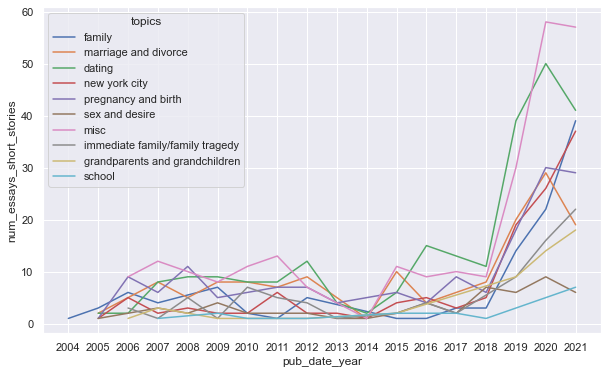

In [850]:
%matplotlib inline 
sns.set(font_scale=1)
plt.figure(figsize=(10,6))
sns.lineplot(data=topics_over_time, x='pub_date_year', y='num_essays_short_stories',hue='topics')

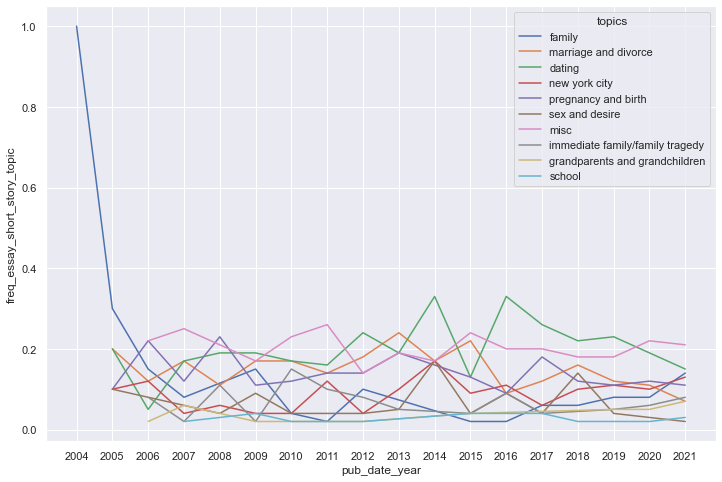

In [851]:
%matplotlib inline 
sns.set(font_scale=1)
plt.figure(figsize=(12,8))
sns.lineplot(data=topics_over_time, x='pub_date_year', y='freq_essay_short_story_topic',hue='topics')

# Plot top words associated with each topic from NMF Model 9

In [860]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=0.6, min_df=.01)
nmf_doc_word = tfidf_vectorizer.fit_transform(corpus)
nmf_topic_modeler = NMF(10, random_state=42, max_iter=1000)
nmf_doc_topic = nmf_topic_modeler.fit_transform(nmf_doc_word)

In [908]:
# save the top words associated with each topic and their corresponding coefficients

# top words
all_top_words = []

vocab = tfidf_vectorizer.get_feature_names()
for idx, topic in enumerate(nmf_topic_modeler.components_):
    all_top_words.append([vocab[i] for i in topic.argsort()[:-10-1:-1]])
    
# top words' coefficients
all_top_words_coeffs = []
for idx, topic in enumerate(nmf_topic_modeler.components_):
    all_top_words_coeffs.append([topic[i] for i in topic.argsort()[:-10-1:-1]])
    
all_top_words = [item for sublist in all_top_words for item in sublist]
all_top_words_coeffs = [item for sublist in all_top_words_coeffs for item in sublist]

all_top_words_coeffs_zipped = list(zip(all_top_words,all_top_words_coeffs))
all_top_words_coeffs_zipped  = [all_top_words_coeffs_zipped[i:i+10] for i in range(0, len(all_top_words_coeffs_zipped ), 10)]

In [988]:
# helper function to generate bar charts of topics and their words with the greatest coefficients

def create_topic_word_chart_nmf(i):
    
    topic_i = []
    
    for topic in all_top_words_coeffs_zipped[i]:
        topic_i.append(topic)
        
    words, coeff = zip(*topic_i)
    s = pd.Series(coeff, words)
    df = pd.DataFrame(s).reset_index().rename(columns={'index':'topic word',
                                                        0:'coefficients'})
    df = df.sort_values('coefficients',ascending=False)
    
    plt.figure(figsize=(5,6))
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    plt.xlim(0,1.5)
    sns.barplot(x='coefficients',y='topic word', data=df,color='pink')
    sns.despine(top=True, right=True, left=False, bottom=False)

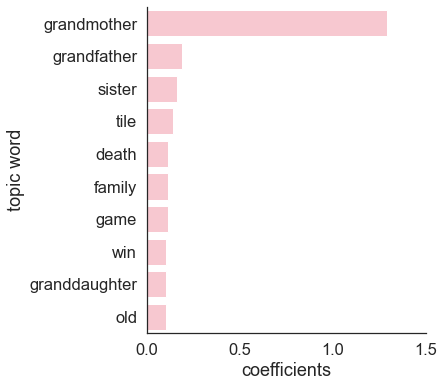

In [989]:
# Plot for grandparents

%matplotlib inline
grand_plot = create_topic_word_chart_nmf(i = 8)
plt.savefig('grand_plot.png',bbox_inches='tight')

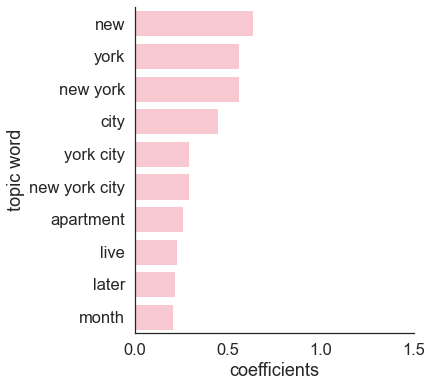

In [990]:
# Plot for nyc

%matplotlib inline
nyc_plot = create_topic_word_chart_nmf(i = 5)
plt.savefig('nyc_plot.png',bbox_inches='tight')

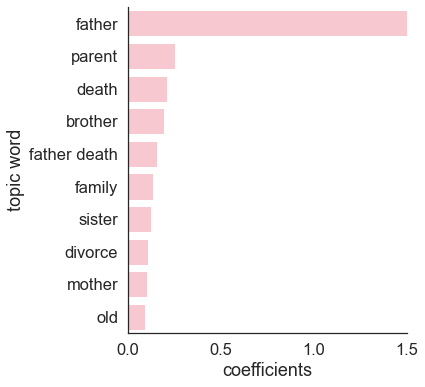

In [1009]:
# Plot for immediate family

%matplotlib inline
imm_family_plot = create_topic_word_chart_nmf(i = 1)
plt.savefig('imm_family_plot.png',bbox_inches='tight')

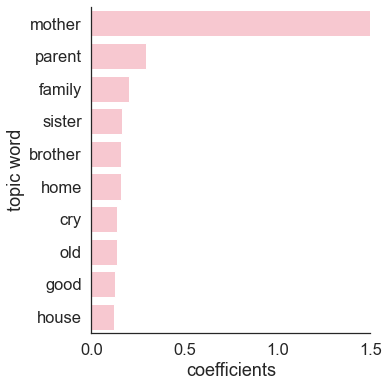

In [1011]:
# Plot for family

%matplotlib inline
family_plot = create_topic_word_chart_nmf(i = 4)
plt.savefig('family_plot.png',bbox_inches='tight')

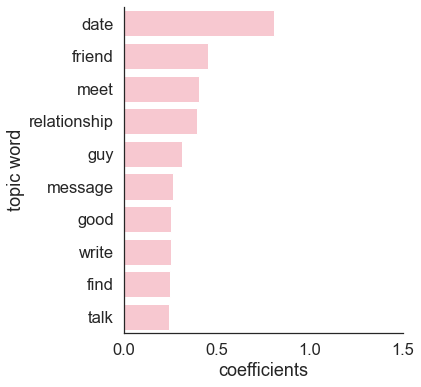

In [991]:
# Plot for dating

%matplotlib inline
dating_plot = create_topic_word_chart_nmf(i = 3)
plt.savefig('dating_plot.png',bbox_inches='tight')

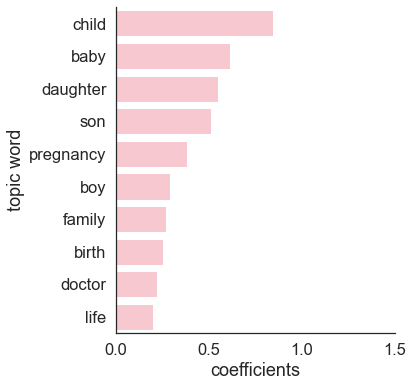

In [995]:
# Plot for pregnancy

%matplotlib inline
pregnancy_plot = create_topic_word_chart_nmf(i = 6)
plt.savefig('pregnancy_plot.png',bbox_inches='tight')

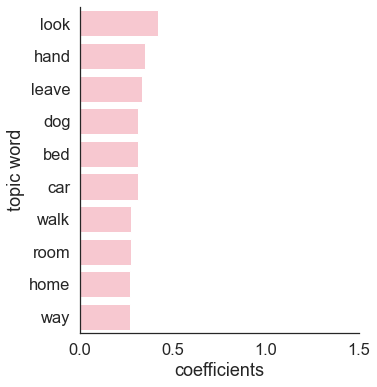

In [1008]:
# Plot for misc

%matplotlib inline
misc_plot = create_topic_word_chart_nmf(i = 0)
plt.savefig('misc_plot.png',bbox_inches='tight')

# Predicting the topic of new essays/short stories with NMF Model 9

In [940]:
# new docs to assign a topic

new_docs = pd.Series(['Durian. It’s love or hate with this fruit. \
            In my family, only Grandma and I were fans. \
            Because of its pungent odor, my family members with milder tastes made a house rule: \
            Durian must be consumed in the parking lot or playground, never indoors. \
            Indignant and banished, I found comfort in Grandma’s solidarity.',
            'The day after an ill-fated second date, I called my little brother as I lay in bed, despondent, \
            in my dingy college apartment. “I don’t have time to come home and do laundry today,” I said. \
            “Oh, and I met someone.” My brother, Felix, listened quietly to my inventory of hesitations: \
            She liked me more than I liked her. She wanted commitment. She lived around the block, and I really \
            didn’t want to hurt her. A pause. My brother said, “You have time for one load. I’ll come get you.”\
            His pragmatic, gentle love is just right. — Ione Madsen Hardy',
           'Being in an abusive relationship is like acting in a play with an erratic director. \
           The script they write unfailingly serves them, affirms them and diminishes you. If you break \
           character (say, hang out with friends or move a houseplant without asking), they will make you pay. \
           So, every day, you get up and improvise to the best of your ability. Day after day of improv, \
           all in service of upholding their narrative and avoiding their wrath. Until, perhaps, you decide to \
           find a partner who will write a story with you, not for you. — Drew Lindgren',
            'Hugh wept talking about his late wife, his best friend. After that first grief support session, I \
            said to my co-facilitator, “I don’t think Hugh will be back.” But he came, all eight weeks. \
            He called it a class, though we kept reminding him it wasn’t. I ran into him months later. \
            I wasn’t looking for romance, but I told him about my swing dance lessons. He asked if he could join; \
            he was such a good dancer. A decade later, politics divide the country. We’re in opposite camps. \
            We can’t watch the news together, but we can dance. — Eileen Vorbach Collins'])

In [941]:
# pre-process new_docs the same ways as the original corpus fit to the model

new_docs = list(nlp.pipe(new_docs))
new_docs_clean = [[token.lemma_.lower() for token in doc if token.is_alpha and \
                          (not token.is_stop and not token.is_punct and not token.like_num and not token.is_digit)] \
                           for doc in new_docs]
new_docs_clean = [' '.join(map(str, l)) for l in new_docs_clean]

new_docs_2 = list(nlp.pipe(new_docs_clean))
new_docs_clean_2 = [[token for token in doc if token.text not in sw_spacy] for doc in new_docs_2]
new_docs_clean_2 = [' '.join(map(str, l)) for l in new_docs_clean_2]
new_docs_clean_2 = list(nlp.pipe(new_docs_clean_2))

new_docs_3 = list(nlp.pipe(new_docs_clean_2))
new_docs_clean_3 = [[token.lemma_ for token in doc] for doc in new_docs_3]
new_docs_clean_3 = [' '.join(map(str, l)) for l in new_docs_clean_3]

In [942]:
# vectorize new_docs_clean_3 on vectorizer fit to original corpus

new_doc_word_vectors_nmf = tfidf_vectorizer.transform(new_docs_clean_3)

In [943]:
# predict topics for each doc in new_docs_clean_3 on NMF model fit to original vectorized corpus

new_doc_topic_nmf = nmf_topic_modeler.transform(new_doc_word_vectors_nmf)

In [946]:
# create dataframe from new_doc_topic_nmf matrix and join it with the text documents

nmf_new_doc_topic_df = pd.DataFrame(new_doc_topic_nmf, columns=['miscellaneous','immediate_family_tragedy',
                                                                'marriage_divorce','dating','family',
                                                               'nyc','pregnancy_birth','sex_affection',
                                                               'grandparents','school'])

nmf_new_doc_topic_df['doc'] = new_docs_clean_3

nmf_new_doc_topic_df['topic'] = nmf_new_doc_topic_df.iloc[:,:10].idxmax(axis=1)

In [947]:
nmf_new_doc_topic_df

,miscellaneous,immediate_family_tragedy,marriage_divorce,dating,family,nyc,pregnancy_birth,sex_affection,grandparents,school,doc,topic
0,0.000000,0.000000,0.003286,0.000000,0.004537,0.000000,0.000000,0.000000,0.253531,0.000000,durian love hate fruit family grandmother fan pungent odor family member milder taste house rule durian consume parking lot playground indoor indignant banish find comfort grandmother solidarity,grandparents
1,0.007135,0.017381,0.000000,0.034732,0.019275,0.026107,0.003458,0.001584,0.000000,0.008199,ill fate date little brother lie bed despondent dingy college apartment home laundry today oh meet brother felix listen quietly inventory hesitation commitment live block hurt pause brother load pragmatic gentle love right ione madsen hardy,dating
2,0.000000,0.001426,0.013047,0.073156,0.000000,0.000000,0.000000,0.021017,0.000000,0.000000,abusive relationship act play erratic director script write unfailingly serve affirm diminish break character hang friend houseplant pay improvise good ability improv service uphold narrative avoid wrath decide find partner write story draw lindgren,dating
3,0.010880,0.000000,0.026126,0.051413,0.009537,0.018485,0.005597,0.000000,0.000487,0.001183,hugh weep talk late wife good friend grief support session co facilitator hugh week class remind run month later look romance swing dance lesson join good dancer decade later politic divide country opposite camp watch news dance eileen vorbach collin,dating


# Topic Modeling with LDA

In [612]:
from sklearn.decomposition import LatentDirichletAllocation

In [1013]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_df=.6)
dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm_tfidf)

make_topics(corpus, vectorizer=tfidf_vectorizer, topic_modeler=lda)

Topic 0: father, mother, friend, marriage, way, child, life, date, talk, look
Topic 1: marriage, husband, friend, mother, look, life, meet, child, long, way
Topic 2: mother, father, child, old, family, life, friend, home, dj, parent
Topic 3: father, mother, life, look, child, friend, new, marriage, husband, date
Topic 4: mother, father, child, life, friend, look, grandmother, find, marriage, parent
Topic 5: look, mother, child, life, friend, husband, date, enjoy, marriage, father
Topic 6: mother, father, marriage, life, friend, new, look, husband, home, date
Topic 7: marriage, father, mother, ring, look, husband, friend, child, leave, life
Topic 8: mother, look, date, life, later, new, father, home, marriage, way
Topic 9: mother, marriage, life, find, father, meet, home, long, friend, new


array([[0.00272089, 0.00272113, 0.00272072, ..., 0.00272076, 0.0027208 ,
        0.00272109],
       [0.00281779, 0.00281814, 0.00281763, ..., 0.00281763, 0.00281796,
        0.00281782],
       [0.97154686, 0.00316174, 0.0031613 , ..., 0.00316114, 0.00316144,
        0.0031614 ],
       ...,
       [0.01012149, 0.01012176, 0.01012137, ..., 0.01012175, 0.01012165,
        0.01012178],
       [0.00801169, 0.00801185, 0.00801154, ..., 0.00801159, 0.92789496,
        0.00801178],
       [0.00815102, 0.00815133, 0.00815056, ..., 0.92664188, 0.00815084,
        0.00815102]])

# Topic Modeling with CorEx

Helpful resources on CorEx
- <a href="https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb">notebook on how to use it</a>

In [93]:
!pip install corextopic
!pip install networkx

In [71]:
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

# CorEx topic modeling utility

In [72]:
def make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None):
    """A very simple pipeline."""
    
    # Vectorize documents into a document-word matrix
    doc_word = vectorizer.fit_transform(corpus)
    doc_word = ss.csr_matrix(doc_word)
    print(doc_word.shape)
    print("")
    
    # Get words that label the columns (needed to extract readable topics and make anchoring easier)
    words = list(np.asarray(vectorizer.get_feature_names()))
    
    # Fit the model
    topic_model = topic_modeler.fit(doc_word)
    if anchor_words:
        topic_model.fit(doc_word, anchors=anchor_words, anchor_strength=anchor_strength, \
                        words=words, docs=corpus)
    else:
        topic_model.fit(doc_word,words=words, docs=corpus)
    
    
    # Print the topics and top words
    topics = topic_model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
     
    # Print total correlation of each topic and the sum of all topics in the model
    print("")
    print(topic_model.tcs)
    print(topic_model.tc)
    
    return topic_model

# CorEx Baseline model

In [264]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(max_features=20000, binary=True)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None)

(1458, 20000)

0: way,come,long,life,look,find,good,try,leave,friend
1: information,sidewalk,reference,supply,accord,knowledge,campus,trap,fantasize,current
2: disapprove,equip,undo,naturally,paddle,parameter,sane,relent,accessory,decipher
3: resentment,apple,traumatize,outgrow,logical,underwater,filter,banter,bent,cascade
4: design,shopping,fertility,trait,cart,boil,cure,magic,futon,dish
5: participate,beam,bookstore,branch,stylish,cabinet,bread,minneapolis,charlie,roast
6: chase,previously,abortion,pursuit,gas,curse,prop,bore,fragile,reproductive
7: conform,novelty,unimaginable,award,stroke,chaperone,spreadsheet,arizona,celebration,delhi

[87.72330266  5.32199851  5.10039868  3.38039333  2.96990819  2.71098833
  2.59114962  1.27169641]
111.06983572249246


# CorEx Model 2 - add anchor words (words from NFM model)

In [924]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=20000, binary=True)
topic_modeler = ct.Corex(n_hidden=5, seed=1) 
anchor_words = [['father','mother','parent','brother','sister','death'],\
                ['sex','date','boyfriend'],\
                ['divorce','marriage'],\
                ['party', 'high school'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 6

corex_doc_topic = make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 20000)

0: father,mother,parent,death,brother,sister,hold,family,child,carry
1: date,sex,boyfriend,relationship,guy,romantic,rest,single,eat,restaurant
2: marriage,way,long,divorce,life,look,find,good,try,leave
3: party,high school,settle,cool,year early,birthday,hotel,tall,anxiety,cross
4: baby,doctor,pregnancy,birth,son,hospital,condition,report,health,hall

[22.19885338 13.31621493 62.43126875 14.37898264 20.62962373]
132.95494341824065


# Plot top words associated with each topic from CorEx Model 2

The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. CorEx also returns the "sign" of each word, which is either 1 or -1. If the sign is -1, then that means the absence of a word is informative in that topic, rather than its presence.

In [925]:
# save the topics and top words associated with each topic (it becomes a list of lists, where each list corresponds
# with a topic and contains tuples with each word, its mutual information, and the word's 'sign'

corex_topics_words = corex_doc_topic.get_topics()

# remove third item in tuple, since we only 
corex_topics_words = [[word[:-1] for word in topic] for topic in corex_topics_words]

In [926]:
# helper function to generate bar charts of topics and their words with the highest mutual info w/ the topic

def create_topic_word_chart(i):
    
    topic_i = []
    
    for topic in corex_topics_words[i]:
        topic_i.append(topic)
        
    words, mi = zip(*topic_i)
    s = pd.Series(mi, words)
    df = pd.DataFrame(s).reset_index().rename(columns={'index':'topic word',
                                                        0:'mutual information'})
    df = df.sort_values('mutual information',ascending=False)
    
    plt.figure(figsize=(5,6))
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    plt.xlim(0,1)
    sns.barplot(x='mutual information',y='topic word', data=df,color='pink')
    sns.despine(top=True, right=True, left=False, bottom=False)

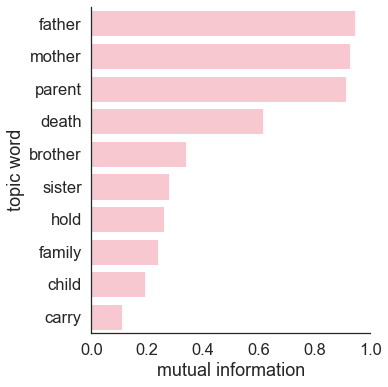

In [927]:
# Plot for family topic

%matplotlib inline
family_plot = create_topic_word_chart(i = 0)
plt.savefig('family_plot.png',bbox_inches='tight')

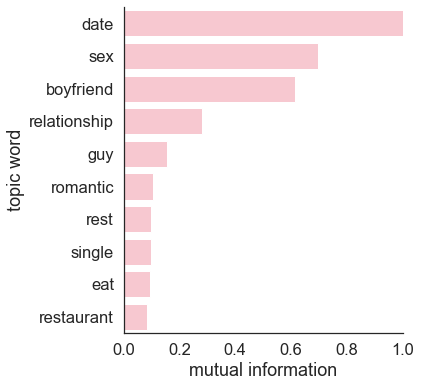

In [928]:
# Plot for dating topic

%matplotlib inline
dating_plot = create_topic_word_chart(i = 1)
plt.savefig('dating_plot.png',bbox_inches='tight')

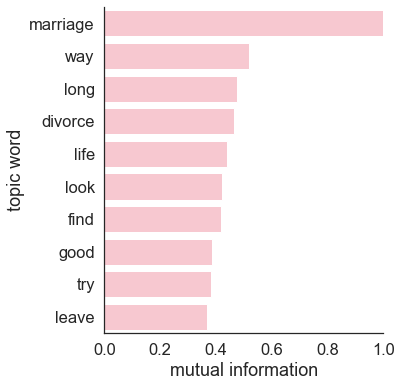

In [929]:
# Plot for marriage and divorce topic

%matplotlib inline
marriage_divorce_plot = create_topic_word_chart(i = 2)
plt.savefig('marriage_divorce_plot.png',bbox_inches='tight')

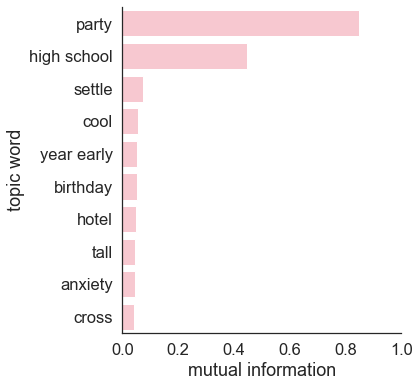

In [930]:
# Plot for school topic

%matplotlib inline
school_plot = create_topic_word_chart(i = 3)
plt.savefig('school.png',bbox_inches='tight')

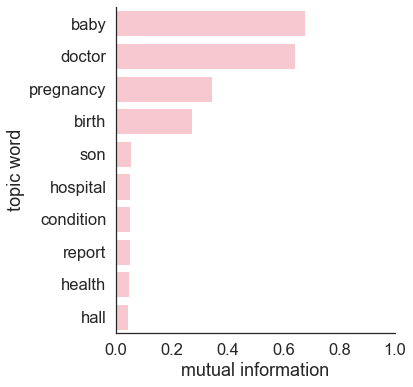

In [931]:
# Plot for pregnancy and birth topic

%matplotlib inline
pregnancy_birth_plot = create_topic_word_chart(i = 4)
plt.savefig('pregnancy_birth.png',bbox_inches='tight')

# Predicting the topic of new content using CorEx Model 2

CountVectorizer and CorEx

In [934]:
# # vectorize new_docs_clean_3 on vectorizer fit to original corpus

corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=20000, binary=True)
doc_word_vectors = vectorizer.fit_transform(corpus)
new_doc_word_vectors = vectorizer.transform(new_docs_clean_3)

In [935]:
# # predict topics for each doc in new_docs_clean_3 on CorEx model fit to original vectorized corpus

new_doc_topic = corex_doc_topic.predict(new_doc_word_vectors)

In [936]:
# create dataframe from new_doc_topic matrix and join it with the text documents

corex_new_doc_topic_df = pd.DataFrame(new_doc_topic, columns=['family','dating','marriage_divorce',
                                                             'school','birth_pregnancy'])

corex_new_doc_topic_df['doc'] = new_docs_clean_3

In [937]:
corex_new_doc_topic_df

,family,dating,marriage_divorce,school,birth_pregnancy,doc
0,False,False,False,False,False,durian love hate fruit family grandmother fan pungent odor family member milder taste house rule durian consume parking lot playground indoor indignant banish find comfort grandmother solidarity
1,False,False,False,False,False,ill fate date little brother lie bed despondent dingy college apartment home laundry today oh meet brother felix listen quietly inventory hesitation commitment live block hurt pause brother load pragmatic gentle love right ione madsen hardy
2,False,False,False,False,False,abusive relationship act play erratic director script write unfailingly serve affirm diminish break character hang friend houseplant pay improvise good ability improv service uphold narrative avoid wrath decide find partner write story draw lindgren
3,False,False,False,False,False,hugh weep talk late wife good friend grief support session co facilitator hugh week class remind run month later look romance swing dance lesson join good dancer decade later politic divide country opposite camp watch news dance eileen vorbach collin


# Analyze number of essays/short stories by topic from CorEx Model 2

In [811]:
corex_doc_topic_df = pd.DataFrame(corex_doc_topic.p_y_given_x) # n_docs x k_topics

In [812]:
corex_doc_topic_df.sample(5)

,0,1,2,3,4
751,0.000001,0.000001,0.000001,0.000001,0.000001
848,0.000001,0.000001,0.000001,0.000001,0.000001
433,0.999999,0.999999,0.999999,0.999999,0.999999
1170,0.000001,0.000001,0.000001,0.000001,0.000001
1211,0.000001,0.000001,0.000001,0.000001,0.000001


In [813]:
corex_modern_love_doc_topic_df = modern_love_df_rev_2.join(corex_doc_topic_df)
corex_modern_love_doc_topic_df = corex_modern_love_doc_topic_df.rename(columns={0:'topic_1',1:'topic_2',
                                                                   2:'topic_3',3:'topic_4',
                                                                   4:'topic_5'})

In [586]:
corex_modern_love_doc_topic_df.loc['total'] = corex_modern_love_doc_topic_df[['topic_1','topic_2','topic_3','topic_4','topic_5']].sum()

In [587]:
total_docs_per_topic = corex_modern_love_doc_topic_df.iloc[-1:,-5:].values
total_docs_per_topic = [item for sublist in total_docs_per_topic for item in sublist]
topics_list = ['Family','Dating','Marriage and Divorce','School','Pregnancy and Birth']

In [588]:
print(total_docs_per_topic)
print(topics_list)

[634.0, 647.0, 663.0, 611.0, 531.0]
['Family', 'Dating', 'Marriage and Divorce', 'School', 'Pregnancy and Birth']


In [589]:
docs_no_topic = len(corex_modern_love_doc_topic_df.loc[(corex_modern_love_doc_topic_df.topic_1 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_2 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_3 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_4 == False) & \
                                                  (corex_modern_love_doc_topic_df.topic_5 == False)])
docs_no_topic

641

In [590]:
total_docs_per_topic.append(docs_no_topic)
topics_list.append('No topic')

In [591]:
s = pd.Series(total_docs_per_topic, topics_list)
df = pd.DataFrame(s).reset_index().rename(columns={'index':'topic',
                                                        0:'total essays/short stories'})
df = df.sort_values('total essays/short stories',ascending=False)

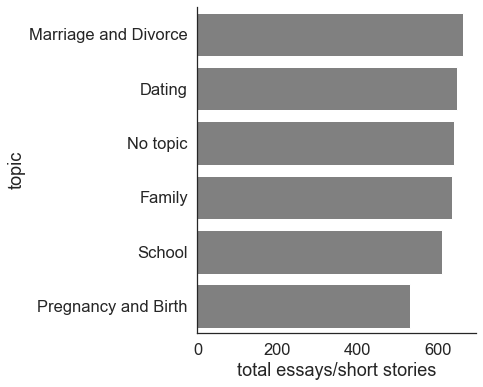

In [592]:
%matplotlib inline

plt.figure(figsize=(5,6))
sns.set(font_scale=1.5)
#sns.set_palette("pastel")
sns.set_style(style='white')
#plt.xlim(0,1)
sns.barplot(x='total essays/short stories',y='topic', data=df, color='gray')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig('docs_per_topic.png',bbox_inches='tight')

# CorEx Model 3 - tune max_df, min_df and ngrams

In [273]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=20000,binary=True,min_df=.01)
topic_modeler = ct.Corex(n_hidden=5, seed=1) 
anchor_words = [['father','mother','parent','brother','sister'],\
                ['sex','date','boyfriend','girlfriend','message'],\
                ['divorce','ex','sex','marriage'],\
                ['school','class','teacher','college'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 6

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 4031)

0: parent,father,mother,brother,begin,sister,family,stand,real,child
1: date,message,sex,girlfriend,boyfriend,online,profile,start date,mail message,text message
2: marriage,sex,way,come,long,divorce,life,look,find,good
3: school,college,class,place,early,watch,word,follow,realize,read
4: baby,doctor,pregnancy,birth,hospital,nurse,healthy,intensive,intensive care,infant

[37.19150201  4.61985162 32.22584163 18.99416746  3.66741986]
96.6987825730295


# CorEx Model 4 - TF-IDF

In [82]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(max_features=20000)
topic_modeler = ct.Corex(n_hidden=8, seed=1)  

make_topics_cx(corpus, vectorizer, topic_modeler, anchor_words=None, anchor_strength=None)

(1458, 20000)

0: way,come,friend,life,relationship,marriage,long,talk,sex,kind
1: akari,frieda,deji,gerri,est,nar,shottsy,que,désolé,cecilia
2: aadmi,pine,pidgin,piano,physics,photocopy,phony,phoebe,phnom,philosophical
3: aaaarrrrgh,pneumonia,plush,plume,plow,plight,pliable,playroom,playoff,playful
4: melina,preston,aah,ponce,pond,ponder,pong,pomplamoose,ponytail,poop
5: aahed,poker,pointillist,poetic,podcast,pocketful,poach,plexu,playhouse,platitude
6: aaa,phu,phonebook,phobic,phobia,phobe,phloem,philosopher,philistines,pharmaceutical
7: greta,aa,prohibition,prohibit,productive,proclaim,proactive,prix,privilege,princeton

[7.16534688e-01 2.19495301e-03 2.40788610e-04 2.02379155e-04
 6.08145305e-05 3.63154012e-05 2.24060036e-05 1.89872635e-05]
0.7193113324286294


# CorEx Model 5 - TF-IDF and tune max_df, min_df and ngrams

In [83]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_df=0.8, min_df=0.01)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 

make_topics_cx(corpus, vectorizer,topic_modeler,anchor_words=None, anchor_strength=None)

(1458, 4032)

0: way,come,friend,life,relationship,long,talk,marriage,kind,look
1: absolutely,nephew,occupy,oh yeah,opinion,overhead,overwhelming,paperwork,paralyze,parent home
2: absorb,professor,progressive,psychiatrist,punch,pure,rank,real world,recipe,replace
3: adoration,ok,old son,paris,parking lot,participate,pattern,pause,payment,permit
4: accustomed,noodle,northern,november,obscure,obsess,obsession,old child,parent divorce,parenting
5: accidentally,new boyfriend,new yorker,newfound,newly,nightly,oblivious,open door,organize,overcome
6: abroad,potato,poverty,proudly,purse,range,rate,reach hand,reader,refugee
7: acquaintance,pillow,poem,poetry,polish,popular,portrait,poster,pretty good,program

[ 9.82199161e-01  1.39147348e-04  1.04990265e-04  4.16248182e-05
  2.72979791e-06 -5.69772392e-06 -2.38193070e-05 -7.30841294e-05]
0.9823850518640102


# CorEx Model 6 - TF-IDF and anchor words

In [84]:
corpus = modern_love_df_rev_2['essay_rev_clean_3']
vectorizer = TfidfVectorizer(max_features=20000,ngram_range=(1,3),max_df=0.8, min_df=.01)
topic_modeler = ct.Corex(n_hidden=8, seed=1) 
anchor_words = [['father','mother','parent','brother','sister'],\
                ['sex','date','boyfriend','girlfriend','message'],\
                ['divorce','ex','sex','marriage'],\
                ['new york','new york city','apartment','manhattan'],\
                ['high school','school','class','teacher','college'],\
                ['birth','doctor','pregnancy','baby']]
anchor_strength = 2

make_topics_cx(corpus, vectorizer,topic_modeler,anchor_words=anchor_words, anchor_strength=anchor_strength)

(1458, 4032)

0: accidentally,punk,puppy,purse,rare,react,recall,recognition,relationship year,relax
1: ache,performance,philadelphia,politic,poorly,portrait,poverty,profound,progress,proud
2: admission,old daughter,olive,online date,opening,orange,oregon,organize,overwhelmed,pace
3: abroad,new year eve,new york,new york city,newfound,nickname,noodle,november,nudge,nursing
4: way,come,friend,life,relationship,long,talk,kind,look,guy
5: accident,peanut,picnic,pink,playful,poet,politely,pose,pregnancy,property
6: accompany,oxygen,pancake,paperwork,park,partnership,patch,path,paycheck,peek
7: absolutely,overwhelm,overwhelming,parade,paralyze,parent home,passenger seat,pattern,pepper,permanently

[-2.08560363e-05 -1.54611908e-06 -3.67686332e-05  1.17328788e-06
  9.55899686e-01 -4.14849007e-06 -1.57200163e-05 -5.48450748e-06]
0.9558163353714854
